In [87]:
import numpy as np
from scipy import ndimage, fft, stats
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import time # import this for measuring execution time

In [88]:
PLOT_RESULTS = True
RADIUS = 30
STD = 5
DPI=120

## 1.1 Fourier transformation

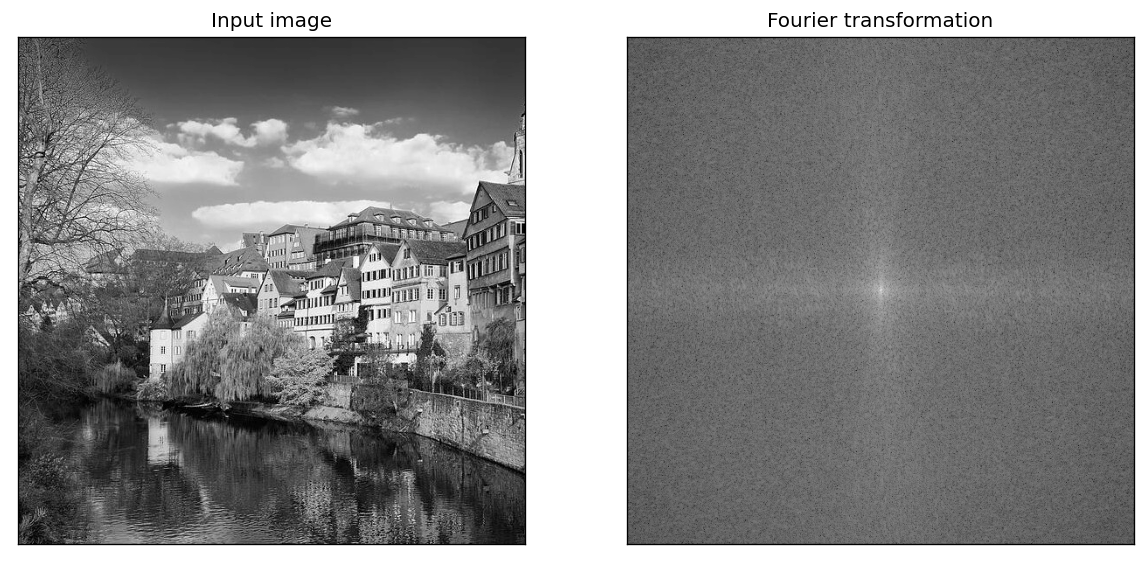

In [89]:
# ----- load the input image
img = imread('inputs/tuebingen.jpg')[:, :, 1] / 255.  
img_size = img.shape[0]


# TODO
FT_img_log = fft.fft2(img)
FT_img_log_centered = fft.fftshift(FT_img_log)


# ----- plot input image together with fourier transformation
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img, cmap = 'gray')
    plt.title('Input image')

    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.log10(abs(FT_img_log_centered)), cmap='gray')
    plt.title('Fourier transformation')
    plt.show()

## 1.2 High-pass filter in spectral space

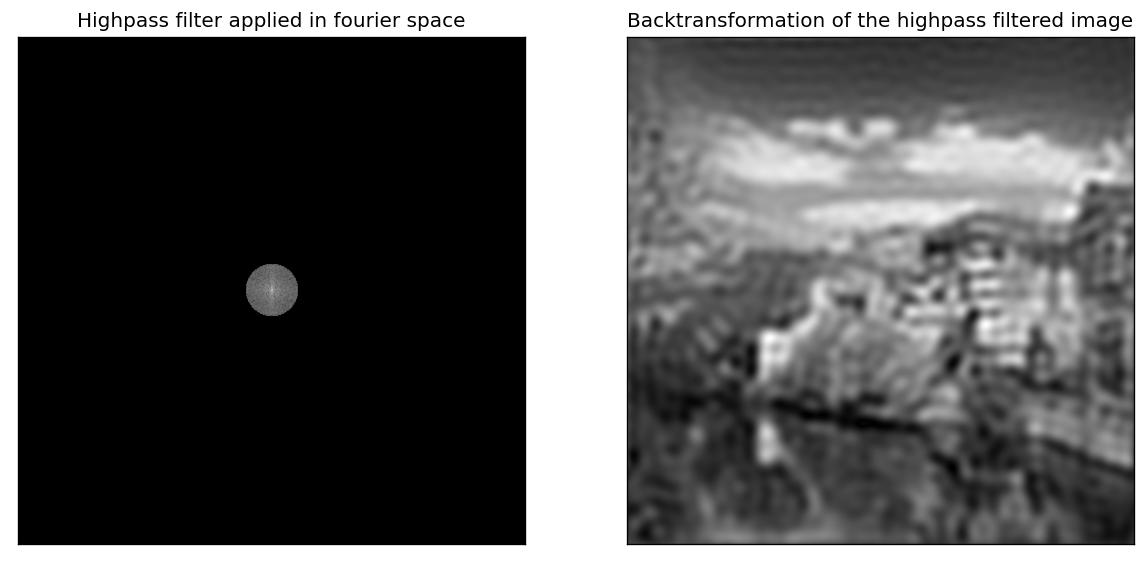

In [90]:
# TODO
def highpass_filter(img_size, radius):
    ''' Returns a highpass filter.
    input:
        img_size: length of the filter
        radius: radius of the circular aperture
    output:
        highpass: a filter of size(img_size, img_size) with values zero and one
    '''
    center = (img_size - 1)/2
    highpass = np.zeros((img_size, img_size))
    for i in range(img_size):
        for j in range(img_size):
            if ((i - center)**2+(j - center)**2)**0.5 < radius:
                highpass[i][j] = 1
    return highpass

# TODO
#   step 2: apply filter (with radius 30) to the spectrum
highpass = highpass_filter(img_size, radius=RADIUS) 
img_highpass = np.where(highpass == 1, FT_img_log_centered, 0)


# TODO
#   step 3: transform the spectrum back to image space                     
img_filtered = fft.ifft2(img_highpass)

if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(img_highpass)**0.15, cmap = 'gray')   # Potenz dient der Kontrastanpassung
    plt.title('Highpass filter applied in fourier space')

    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(abs(img_filtered), cmap=plt.cm.gray)
    plt.title('Backtransformation of the highpass filtered image')
    plt.show()

## 1.3 Gaussian filter

### 1.3.1 Construct a Gaussian filter

In [91]:
# TODO
def g_kern(kernlen=5, std=1):
    ''' Returns a 2D Gaussian kernel with standard devitation sig
    input:
        kernlen: length of the filter
        std: standard deviation of the gaussian in pixels
    output:
        g_kern_2d: a gaussian kernel of size (kernlen, kernlen) with sum 1
    '''
    center = (kernlen - 1)/2
    g_kern_2d = np.zeros((kernlen, kernlen))
    for i in range(kernlen):
        for j in range(kernlen):
            g_kern_2d[i][j] = stats.norm.pdf(((i - center)**2 + (j - center)**2)**0.5, loc=0, scale=std)  # using pdf instead of cdf
    return g_kern_2d

### 1.3.2 Apply Gaussian filter in image space

In [92]:
# TODO
#   step 2: create such a gaussian filter with standard deviation 5 and filtersize=image_size and
#           convolve the image with this filter 
gaussfilter_img = g_kern(img_size, 5)
img_conv = ndimage.convolve(img, g_kern(30, 5))

### 1.3.3 Transform the Gaussian filter to fourier space

In [93]:
# TODO
#   step 3: transform the gaussian kernel to fourier space
gaussfilter_f = fft.fft2(gaussfilter_img)
gaussfilter_f_shift = fft.fftshift(gaussfilter_f)

### 1.3.4 Apply this filter in fourier space

In [94]:
f_gauss = abs(gaussfilter_f) * FT_img_log
img_gauss_f = fft.ifft2(f_gauss)

### 1.3.5. Visuallise and compare two filtering methods

difference: 0.072993813979935


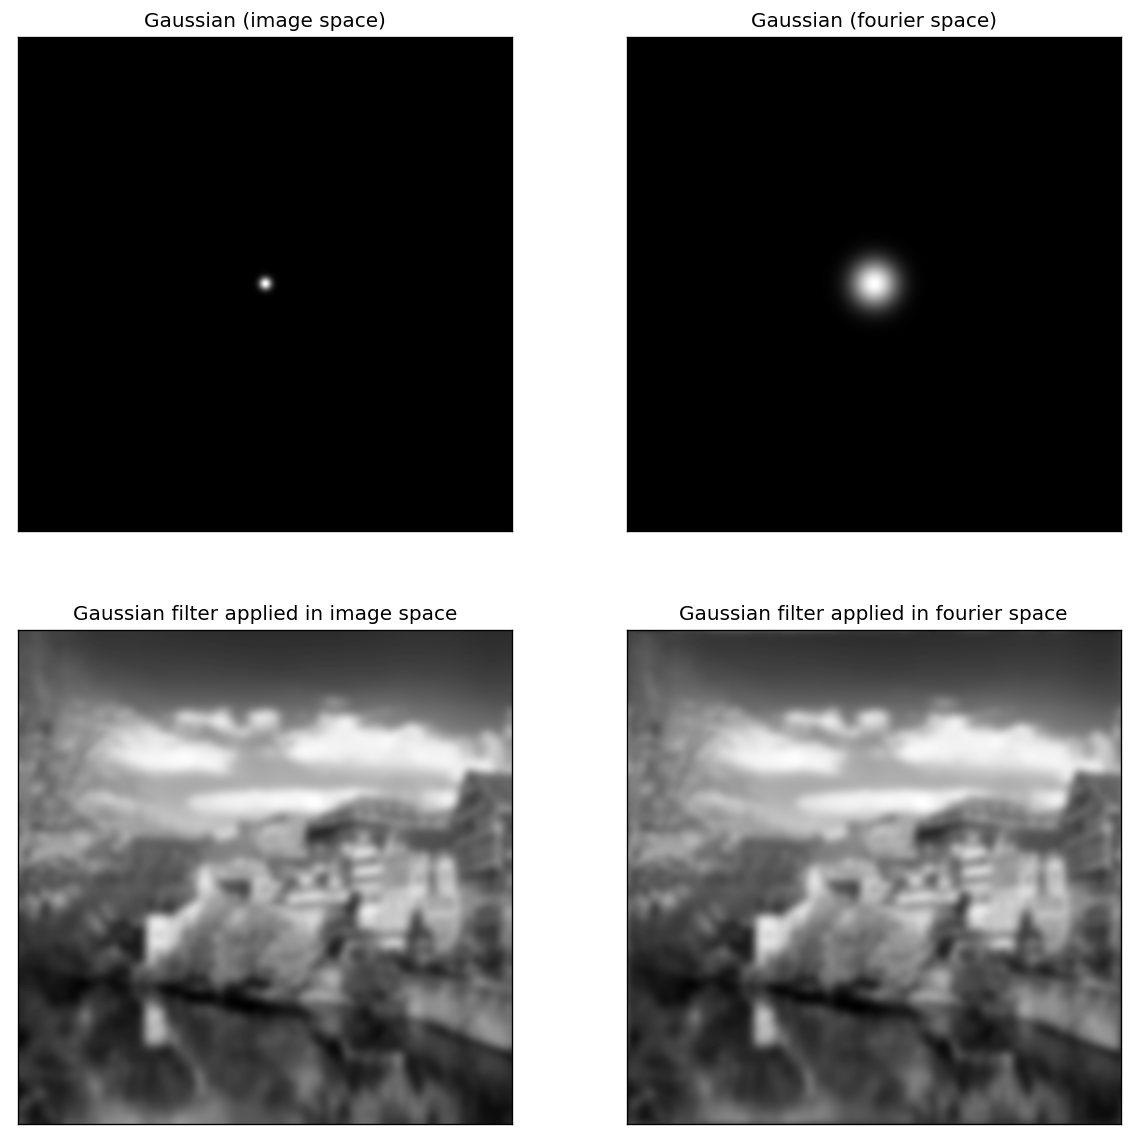

In [95]:
#   step 5: compare the results
difference = np.mean(np.abs(img_gauss_f - img_conv))       
print('difference: ' + str(difference))

if PLOT_RESULTS:
    # compare the two images
    plt.figure(figsize=(12, 12),dpi=DPI)

    plt.subplot(221)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((gaussfilter_img), cmap=plt.cm.gray)
    plt.title('Gaussian (image space)')

    plt.subplot(222)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.abs(gaussfilter_f_shift), cmap=plt.cm.gray)
    plt.title('Gaussian (fourier space)')

    plt.subplot(223)        # plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      # img_conv
    plt.title('Gaussian filter applied in image space')

    plt.subplot(224)        # plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow(abs(img_gauss_f), cmap=plt.cm.gray)
    plt.title('Gaussian filter applied in fourier space')

    plt.show()

### 1.3.6 Splitted convolutional filter

combined convolution average execution time: 653.27ms
seperate convolution average execution time: 38.13ms


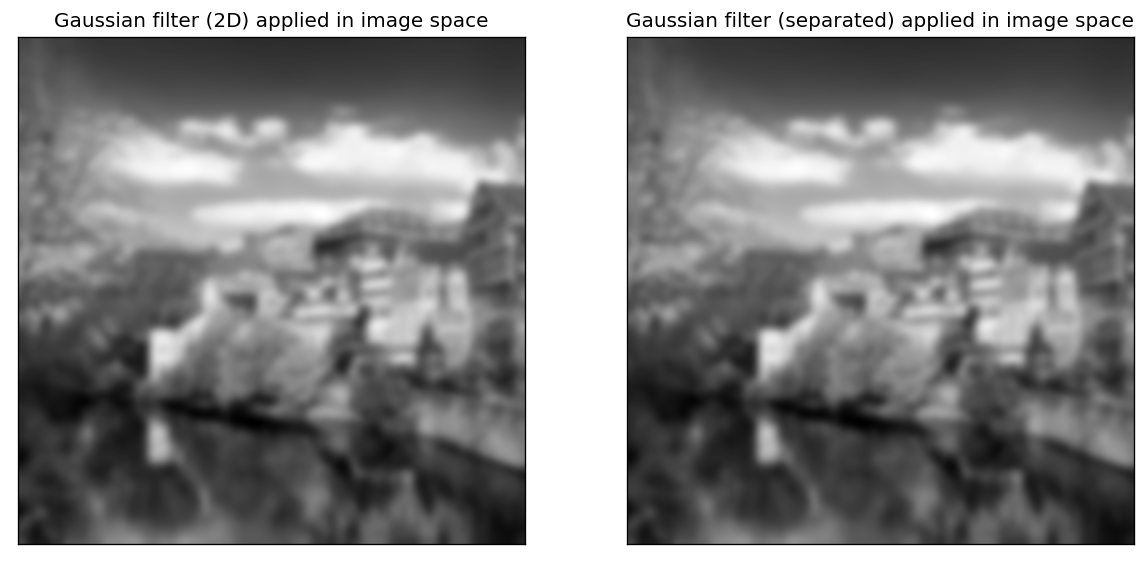

In [98]:
# TODO
def g_kern1d(kernlen=5, std=1):
    '''
    Returns a 1D Gaussian kernel with standard devitation sig 
    input:
        kernlen: length of the filter std: standard deviation of the gaussian in  pixels 
    output: 
        g_kern_1d: a gaussian kernel of size (kernlen, 1)
    '''
    center = (kernlen - 1)/2
    g_kern_1d = np.zeros((kernlen, 1))
    for i in range(kernlen):
        g_kern_1d[i] = stats.norm.pdf(abs(i - center), loc=0, scale=std)
    return g_kern_1d

gaussfilter_img_1D = g_kern1d(30, 5)
img_conv_sep_final = ndimage.convolve(ndimage.convolve(img, gaussfilter_img_1D), gaussfilter_img_1D.T)

# ----- measure execution time
exec_time_comb = np.zeros((20, 1))
for i in range(len(exec_time_comb)):
    img_conv_test = None
    start = time.time()
    img_conv_test = ndimage.convolve(img, g_kern(30, 5))
    end = time.time()
    exec_time_comb[i] = end - start
print('combined convolution average execution time: {:.2f}ms'.format(1000*np.mean(exec_time_comb)))

exec_time_sep = np.zeros((20, 1))
for i in range(len(exec_time_sep)):
    img_conv_sep_test = None
    start = time.time()
    img_conv_sep_test = ndimage.convolve(ndimage.convolve(img, g_kern1d(30, 5)), g_kern1d(30, 5).T)
    end = time.time()
    exec_time_sep[i] = end - start
print('seperate convolution average execution time: {:.2f}ms'.format(1000*np.mean(exec_time_sep)))

# ----- plot results
if PLOT_RESULTS:   #plot_results:
    plt.figure(figsize=(12, 12),dpi=DPI)
    plt.subplot(121)
    plt.xticks([]), plt.yticks([])
    plt.imshow((img_conv), cmap=plt.cm.gray)      
    plt.title('Gaussian filter (2D) applied in image space')
    plt.subplot(122)
    plt.xticks([]), plt.yticks([])
    plt.imshow(img_conv_sep_final, cmap='gray')
    plt.title('Gaussian filter (separated) applied in image space')
    plt.show()